In [44]:
import pandas as pd
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5001")

In [45]:
ratings = pd.read_csv('../data/ml-32m/ratings.csv')
df_users = pd.read_csv('../data/ml-32m/users.csv')
df_movies = pd.read_csv('../data/ml-32m/movies.csv')

#df_movies.loc[df_movies['IMDB URL'].isna(), 'IMDB URL'] = ''

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])

ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,944249077
1,1,2,1.0,944250228
2,1,3,2.0,943230976
3,1,4,5.0,944249077
4,1,5,5.0,943228858


In [46]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [47]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

200948 84432 200948 80202


In [48]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5.0, 0.5, 3.540257224143456)

In [49]:
#Seteo del experimento
experiment_name = "Neural Network 32 M"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/496846399806627028', creation_time=1731957405074, experiment_id='496846399806627028', last_update_time=1731957405074, lifecycle_stage='active', name='Neural Network 32 M', tags={}>

In [50]:
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dense, Activation, Lambda
from keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam

In [51]:
mlflow.start_run(run_name="Early Stoping + latent factor 5 + dropout + 5 epochs + 150 neurons + lr reduce on plateau")

<ActiveRun: >

In [52]:
n_latent_factors_user = 5
mlflow.log_param("n_latent_factors_user", n_latent_factors_user)
n_latent_factors_movie = 5
mlflow.log_param("n_latent_factors_movie", n_latent_factors_movie)

5

In [53]:
movie_embedding_regularizer = 0.001
mlflow.log_param("movie_embedding_regularizer_l2", movie_embedding_regularizer)

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding', embeddings_regularizer = l2(movie_embedding_regularizer))(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(0.2)(movie_vec)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = Dropout(0.2)(user_vec)

concat = Concatenate(name='Concat')([movie_vec, user_vec])
concat = Dropout(0.2)(concat)

x = Dense(150,name='FullyConnected-1', activation='relu')(concat)
x = Dropout(0.5)(x)
# x = Dense(50,name='FullyConnected-1', activation='relu')(concat)
# x = Dropout(0.5)(x)


## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
x = Dense(1, activation='sigmoid',name='Activation')(x)
x = Lambda(lambda z: (max_rating - min_rating) * z + min_rating)(x)
##

model = Model([user_input, movie_input], x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 5)         422165      ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         1004745     ['User[0][0]']                   
                                                                                            

In [54]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [55]:
lr = 0.001
model.compile(Adam(learning_rate=lr), 'mean_squared_error', metrics=[root_mean_squared_error])
mlflow.log_param("lr", lr)

0.001

In [56]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpointer = ModelCheckpoint(filepath='weights1.hdf5', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')

In [57]:
from tensorflow.keras.callbacks import EarlyStopping
patience = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
mlflow.log_param("early_stopping_patience", patience)

5

In [58]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Métrica a monitorear (puede ser 'val_loss' o 'loss')
    factor=0.5,              # Factor de reducción del learning rate (e.g., reduce a la mitad)
    patience=5,              # Número de épocas sin mejora antes de reducir
    min_lr=1e-6,             # Learning rate mínimo permitido
    verbose=1                # Mostrar logs cuando se reduzca el LR
)
mlflow.log_param("reduce_lr", reduce_lr)

In [59]:
batch_size = 320
epochs = 5
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)

history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    batch_size = batch_size,
                    callbacks = [checkpointer, early_stopping, reduce_lr],
                    epochs=epochs, verbose=1)

Epoch 1/5
79995/80001 [============================>.] - ETA: 0s - loss: 0.8576 - root_mean_squared_error: 0.9075
Epoch 1: val_root_mean_squared_error improved from inf to 0.88213, saving model to weights1.hdf5
80001/80001 [==============================] - 360s 4ms/step - loss: 0.8576 - root_mean_squared_error: 0.9075 - val_loss: 0.8117 - val_root_mean_squared_error: 0.8821 - lr: 0.0010
Epoch 2/5
79996/80001 [============================>.] - ETA: 0s - loss: 0.8317 - root_mean_squared_error: 0.8934
Epoch 2: val_root_mean_squared_error improved from 0.88213 to 0.87824, saving model to weights1.hdf5
80001/80001 [==============================] - 358s 4ms/step - loss: 0.8317 - root_mean_squared_error: 0.8934 - val_loss: 0.8051 - val_root_mean_squared_error: 0.8782 - lr: 0.0010
Epoch 3/5
79992/80001 [============================>.] - ETA: 0s - loss: 0.8232 - root_mean_squared_error: 0.8886
Epoch 3: val_root_mean_squared_error improved from 0.87824 to 0.87781, saving model to weights1.hdf5

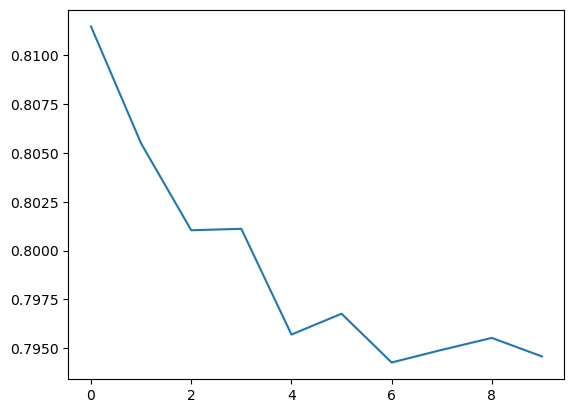

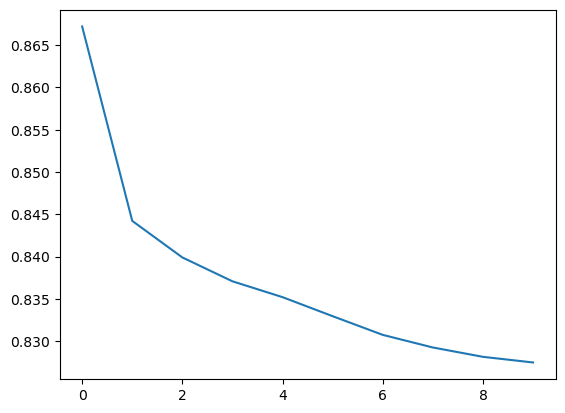

In [42]:
from matplotlib import pyplot as plt

plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

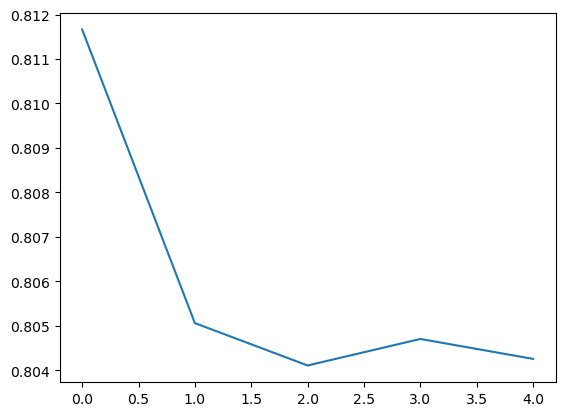

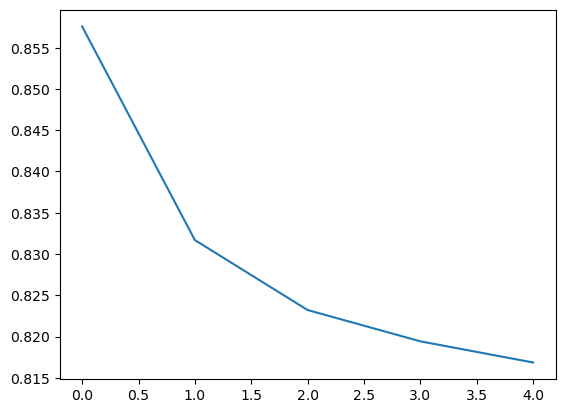

In [60]:
from matplotlib import pyplot as plt

plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

In [61]:
for key, value in history.history.items():
  mlflow.log_metric(key, value[-1]) 

In [37]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

 59412/200002 [=======>......................] - ETA: 1:33 - loss: 0.7938 - root_mean_squared_error: 0.8630

KeyboardInterrupt: 

In [62]:
model.load_weights('weights1.hdf5')
mse, rmse = model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)
mlflow.log_metric("val_mse", mse) 
mlflow.log_metric("val_rmse", rmse) 

200002/200002 [==============================] - 122s 609us/step - loss: 0.8041 - root_mean_squared_error: 0.8686


In [39]:
movie_embeddings_layer = model.layers[2]
user_embeddings_layer = model.layers[3]

movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [63]:
mlflow.keras.log_model(model, "best_model")

2024/11/18 18:23:11 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/7f/19f36bv57_72qpq3mfj1x6240000gn/T/tmplik1yu1p/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/7f/19f36bv57_72qpq3mfj1x6240000gn/T/tmplik1yu1p/model/data/model/assets
2024/11/18 18:23:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/7f/19f36bv57_72qpq3mfj1x6240000gn/T/tmplik1yu1p/model, flavor: tensorflow). Fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/18 18:23:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [64]:
mlflow.end_run()

2024/11/18 18:23:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run Early Stoping + latent factor 5 + dropout + 5 epochs + 150 neurons + lr reduce on plateau at: http://127.0.0.1:5001/#/experiments/496846399806627028/runs/df763bb28e874dd6a3367383038ac07a.
2024/11/18 18:23:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/496846399806627028.


#### Hay una diferencia de 1 entre n_movies, n_users y  el shape de las matrices de embeddigs

In [61]:
movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
user_embeddings_matrix = user_embeddings_layer.get_weights()[0]

movie_embeddings_matrix.shape, user_embeddings_matrix.shape, n_movies, n_users

((1683, 5), (944, 5), 1682, 943)

In [62]:
import numpy as np

np.save('../data/vector_db/movie_embeddings_matrix_1.npy', movie_embeddings_matrix)
np.save('../data/vector_db/user_embeddings_matrix_1.npy', user_embeddings_matrix)
np.save('../data/vector_db/user2Idx_1.npy', user2Idx)
np.save('../data/vector_db/movie2Idx_1.npy', movie2Idx)